# Experiment on PubMed dataset

In [1]:
# import packages
import numpy as np
import scipy
from scipy.linalg import eigh
import scipy.sparse as sp
import scipy.io as io
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.preprocessing import normalize
from sklearn.manifold import TSNE, spectral_embedding
from sklearn.linear_model import LogisticRegression

import torch
import torch.nn as nn
import torch.nn.functional as F

import time
import os
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import get_laplacian, remove_self_loops
import math

## Read Data

In [2]:
dataset = Planetoid(root='../../data', name='pubmed')
data = dataset[0]
X = data.x
y = data.y

## Define graph A and Laplacian L

In [3]:
class_num = 3
m, D = X.shape
edge_index, edge_weight = get_laplacian(data.edge_index, normalization='sym')
L_sym = torch.sparse.FloatTensor( edge_index, edge_weight, (m, m) )

edge_index, edge_weight = remove_self_loops( edge_index, -edge_weight )
A_sym = torch.sparse.FloatTensor( edge_index, edge_weight, (m, m) )

## Laplacian EigenNet

### Define the LENet model

In [4]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [5]:
class Encoder_linear(nn.Module):
    def __init__(self, n_feat, dim):
        super(Encoder_linear, self).__init__()
        self.W = nn.Parameter(torch.FloatTensor(n_feat, dim))
        self.bias = nn.Parameter(torch.empty(1, dim))
        self.n_feat = n_feat
        self.dim = dim
        self.reset_parameters()

    def reset_parameters(self):
        stdv = math.sqrt(3) / math.sqrt(self.n_feat)
        self.W.data.uniform_(-stdv, stdv)
        self.bias.data.uniform_(-stdv, stdv)

    def forward(self, X):
        X = F.dropout(X, training = self.training, p = 0.9)
        Z = torch.mm(X, self.W) + self.bias
        Z = F.normalize(Z)
        return Z

def LENet( Z, A, beta, K = 32):
    m, d = Z.shape
    alpha = m*(1-beta*0.95)/d
    # ! Propagate
    Y = Z
    Y_all = Y
    for _ in range(K):
        Y = beta * torch.spmm(A, Y)
        Y_all = Y_all + Y
    # ! Linear Transformation
    Y = Y_all
    U, s, _ = torch.linalg.svd( Z.T @ Y, full_matrices = True)
    s_inv_21 = 1 / torch.sqrt(s)
    W = ( U*s_inv_21 ) @ U.T
    Y = np.sqrt(alpha) * (Y @ W)
    return Y

def align_fun(Z, Y):
    return torch.mean( torch.sum( Z*Y, dim = 1 ) )

### Start to train LENet

In [6]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

class Build_Data(Dataset):
    # Constructor
    def __init__(self, X):
        self.X = X
        self.len = self.X.shape[0]
    # Getting the data
    def __getitem__(self, index):
        return self.X[index], index
    # Getting length of the data
    def __len__(self):
        return self.len

In [7]:
beta = 0.9
dim_d = 12

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Encoder_linear(n_feat=D, dim=dim_d).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9, weight_decay=0, maximize = True)

A = A_sym.to(device)
X = X.to(device)
X_Data = Build_Data(X)
train_loader = DataLoader(X_Data, batch_size=1024, shuffle=True, drop_last=False)

epoch = 0
align_epoch = []

for iter in range(520):
    if iter % 10 == 0:
        model.eval()
        with torch.no_grad():
            Z = model(X)
            Y = LENet( Z, A, beta, K = 32 )
    model.train()
    for X_batch, index in train_loader:
        optimizer.zero_grad()
        Z_batch = model(X_batch)
        align = align_fun(Z_batch, Y[index])
        align.backward()
        optimizer.step()
        # ! compute align value
        align_epoch.append(align.item())
        epoch = epoch + 1
        print(  'iter:{:04d}'.format(iter+1), 
                'epoch:{:04d}'.format(epoch), 
                '| align_epoch:{:.3f}'.format(align_epoch[-1]) )

iter:0001 epoch:0001 | align_epoch:0.301
iter:0001 epoch:0002 | align_epoch:0.327
iter:0001 epoch:0003 | align_epoch:0.294
iter:0001 epoch:0004 | align_epoch:0.305
iter:0001 epoch:0005 | align_epoch:0.317
iter:0001 epoch:0006 | align_epoch:0.306
iter:0001 epoch:0007 | align_epoch:0.327
iter:0001 epoch:0008 | align_epoch:0.315
iter:0001 epoch:0009 | align_epoch:0.339
iter:0001 epoch:0010 | align_epoch:0.335
iter:0001 epoch:0011 | align_epoch:0.336
iter:0001 epoch:0012 | align_epoch:0.321
iter:0001 epoch:0013 | align_epoch:0.320
iter:0001 epoch:0014 | align_epoch:0.341
iter:0001 epoch:0015 | align_epoch:0.328
iter:0001 epoch:0016 | align_epoch:0.328
iter:0001 epoch:0017 | align_epoch:0.327
iter:0001 epoch:0018 | align_epoch:0.335
iter:0001 epoch:0019 | align_epoch:0.323
iter:0001 epoch:0020 | align_epoch:0.321
iter:0002 epoch:0021 | align_epoch:0.340
iter:0002 epoch:0022 | align_epoch:0.324
iter:0002 epoch:0023 | align_epoch:0.333
iter:0002 epoch:0024 | align_epoch:0.337
iter:0002 epoch:

In [8]:
model.eval()
with torch.no_grad():
    Z = model(X)
    Y = LENet( Z, A, beta, K = 32 )

Z = Z.cpu()
Y = Y.cpu()
Y_norm = normalize(Y)

Z_train = Z[data.train_mask]
Z_test = Z[data.test_mask]
Y_train = Y[data.train_mask]
Y_test = Y[data.test_mask]
Y_norm_train = Y_norm[data.train_mask]
Y_norm_test = Y_norm[data.test_mask]

y_train = y[data.train_mask]
y_test = y[data.test_mask]

clf = LogisticRegression()
clf.fit( Z_train, y_train )
acc_Z = clf.score( Z_test, y_test )

clf = LogisticRegression()
clf.fit( Y_train, y_train )
acc_Y = clf.score( Y_test, y_test )

clf = LogisticRegression()
clf.fit( Y_norm_train, y_train )
acc_Y_norm = clf.score( Y_norm_test, y_test )

In [9]:
acc_Z, acc_Y, acc_Y_norm

(0.763, 0.789, 0.805)

### Parameter setting tip

Since we train the linear encoder to minimize objective function $\| Z - Y\|_F$, to reach a reasonable result, it is recommended to tune the parameter $\beta$ (so $\alpha$) such that $\|Y\|_F \approx \| Z\|_F = m$. In pubmed dataset case, $m = 19717$.

In [10]:
np.power( np.linalg.norm(Y, 'fro'), 2 )

17161.83954884205

## Visualizing result

plot tsne

In [11]:
Y_tsne = TSNE(
            n_components=2,
            perplexity=5,
            init="pca",
            random_state=42,
            ).fit_transform( Y )

d:\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
d:\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


In [12]:
def symmetric_normalize(A):
    # normalize a symmeteric adjacency matrix
    row_sum = A.sum(axis=1)
    row_sum = (row_sum==0)*1 + row_sum
    D_inv_21 = sp.csr_array( sp.diags( np.power(row_sum, -0.5) ) )
    A_sym = D_inv_21 @ A @ D_inv_21
    return A_sym

A_plot = sp.coo_matrix( (np.ones_like(data.edge_index[0]), (data.edge_index[0], data.edge_index[1])), shape=(data.num_nodes, data.num_nodes) )

A_plot = sp.csr_array(A_plot)
# Symmetry: A := A + (AT-A)[AT>A]
A_plot =  A_plot + (A_plot.T - A_plot) * (A_plot.T > A_plot)

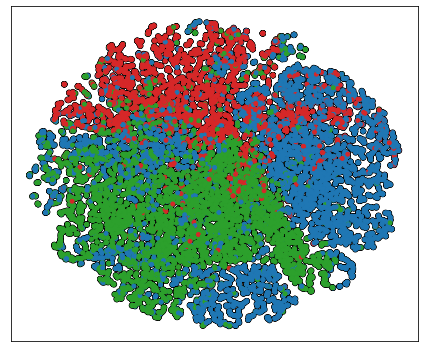

In [13]:
def plot_scatter_with_edge(ax, Z, fig_paras, A):
    def plot_graph_edges(A):
        indptr = A.indptr
        indices = A.indices
        repeat_num = indptr[1:] - indptr[:-1]
        edge_begin = np.repeat(Z, repeat_num, axis = 0)
        edge_over = np.vstack( [ Z[indices[indptr[i]:indptr[i+1]]] for i in range(m) ] )
        x,y = edge_begin[:, 0], edge_begin[:, 1]
        u,v = edge_over[:, 0]-x, edge_over[:, 1]-y
        ax.quiver(x,y, u,v, color='k', lw=0.1, alpha=0.1, angles='xy', scale_units='xy', scale=1)
    # plot_graph_edges(A)
    ax.scatter(Z[:, 0], Z[:, 1], **fig_paras, edgecolors='k', lw=2, zorder=1,s=18)
    ax.scatter(Z[:, 0], Z[:, 1], **fig_paras, zorder=1, s=15)

colors = np.asarray( ['C3', 'C2', 'C0'] )

fig_paras = {
            'c': colors[y],
            # 'edgecolors': 'gray',
            # 'lw': 0.05,
            'alpha': 1,
            # 's': 20, 
}
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']
fig, ax = plt.subplots(figsize=(6, 5))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])
plot_scatter_with_edge(ax, Y_tsne, fig_paras, A_plot)
fig.tight_layout()

save heatmap

In [14]:
X_norm = normalize(X.cpu())

X_s = np.vstack( [ X_norm[y==j] for j in range(3) ] )
Y_s = np.vstack( [ Y_norm[y==j] for j in range(3) ] )

sim_X = np.abs(X_s @ X_s.T)
sim_Y = np.abs(Y_s @ Y_s.T)

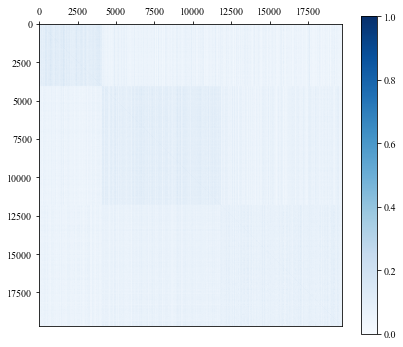

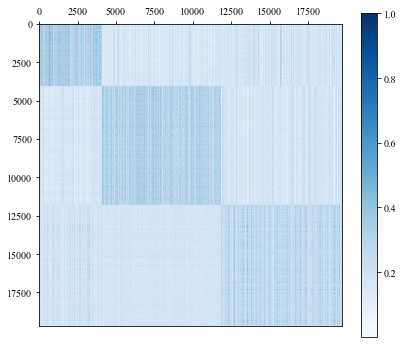

In [15]:
def plot_heatmap(fig, ax, sim, cmap):
    im = ax.imshow(sim, cmap=cmap, origin='upper')
    ax.xaxis.tick_top()
    ax.set_box_aspect(1)
    fig.colorbar(im)

cmap = 'Blues'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']
fig_X, ax_X = plt.subplots(figsize=(6, 5))
fig_Z, ax_Z = plt.subplots(figsize=(6, 5))
plot_heatmap(fig_X, ax_X, sim_X, cmap)
plot_heatmap(fig_Z, ax_Z, sim_Y, cmap)
fig_X.tight_layout()
fig_Z.tight_layout()

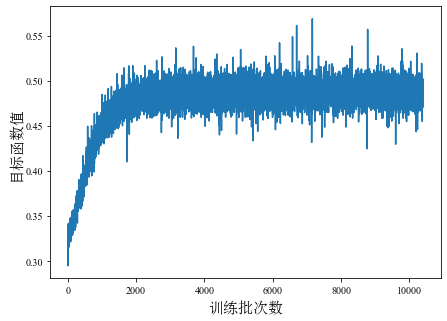

In [16]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']
fontsize = 15
color_origin = 'tab:blue'

fig, ax = plt.subplots(figsize=(7,5))
ax.set_xlabel('训练批次数', fontproperties="SimSun", fontsize=fontsize)
ax.set_ylabel('目标函数值', fontproperties="SimSun", color='k', fontsize=fontsize)
# ax.tick_params(axis='y', labelcolor=color_origin)
ax.plot(align_epoch, label='loss', color=color_origin)